In [1]:
%matplotlib notebook

In [77]:
from importlib import reload
from typing import Dict, Tuple, List, Union, Sequence, Optional

import numpy as np
from matplotlib import pyplot as plt

In [78]:
import qcodes as qc
from qcodes.instrument.base import Instrument, InstrumentBase
from qcodes.instrument.parameter import Parameter, ArrayParameter

from pytopo.qctools.instruments import create_inst

In [85]:
class HardSweep(Instrument):
    
    def __init__(self, name: str, sweep_dims: Sequence, **kw):
        
        self.sweep_dims = sweep_dims        
        self.sweep_units = kw.pop('sweep_units', ['' for d in self.sweep_dims])
        
        super().__init__(name, **kw)
        
        self.sweep_params = []
        for i, n in enumerate(self.sweep_dims):
            self.add_parameter(n, set_cmd=None, unit=self.sweep_units[i],
                               snapshot_value=False)
            self.sweep_params.append(getattr(self, n))

        self._meta_attrs = ['sweep_dims']
    
    def setup(self):
        self.sweep_shape = tuple([len(p()) for p in self.sweep_params])
        
    def get_sweep_grid(self):
        return np.meshgrid( *[p() for p in self.sweep_params], indexing='ij')
    
    def get_sweep_coord_zip(self):
        return list(zip(*[s.reshape(-1) for s in self.get_sweep_grid()]))
    
    def get_sweep_coords(self):
        return list(zip(self.sweep_params, [s.reshape(-1) for s in self.get_sweep_grid()]))
        

class HardSweepDetector(Instrument):
    
    def __init__(self, name: str, inner_dims: Sequence, 
                 sweeper: Optional[HardSweep]=None, **kw):
        
        self.inner_dims = inner_dims
        self.inner_units = kw.pop('inner_units', ['' for d in self.inner_dims])
        
        super().__init__(name, **kw)
        
        self.set_sweeper(sweeper)
        
        self.inner_params = []
        for i, n in enumerate(self.inner_dims):
            self.add_parameter(n, set_cmd=None, unit=self.inner_units[i],
                               snapshot_value=False)
            self.inner_params.append(getattr(self, n))

        self._meta_attrs = ['inner_dims']
        
    def set_sweeper(self, swp):
        self.sweeper = swp
    
    def setup(self):
        self.inner_shape = tuple([len(p()) for p in self.inner_params])
        self.sweep_shape = [] if self.sweeper is None else list(self.sweeper.sweep_shape).copy()
        self.sweep_shape += self.inner_shape
        self.sweep_shape = tuple(self.sweep_shape)
        
        self.sweep_dims = [] if self.sweeper is None else self.sweeper.sweep_dims.copy()
        self.sweep_dims += self.inner_dims
        
        self.sweep_units = [] if self.sweeper is None else self.sweeper.sweep_units.copy()
        self.sweep_units += self.inner_units
        
        self.sweep_params = [] if self.sweeper is None else self.sweeper.sweep_params.copy()
        self.sweep_params += self.inner_params
       
    def get_inner_grid(self):
        return np.meshgrid( *[p() for p in self.inner_params], indexing='ij')
    
    def get_inner_coord_zip(self):
        return list(zip(*[s.reshape(-1) for s in self.get_inner_grid()]))
    
    def get_inner_coords(self):
        return list(zip(self.inner_params, [s.reshape(-1) for s in self.get_inner_grid()]))
    
    def get_sweep_grid(self):
        return np.meshgrid( *[p() for p in self.sweep_params], indexing='ij')
    
    def get_sweep_coord_zip(self):
        return list(zip(*[s.reshape(-1) for s in self.get_sweep_grid()]))
    
    def get_sweep_coords(self):
        return list(zip(self.sweep_params, [s.reshape(-1) for s in self.get_sweep_grid()]))

In [92]:
class HardRabi(HardSweep):
    
    def __init__(self, name: str, **kw):
        super().__init__(name, sweep_dims=['amplitude', 'detuning'], 
                         sweep_units=['a.u.', 'Hz'], **kw)
        
        self.add_parameter('start_amp', get_cmd=None, set_cmd=None,
                           unit='a.u.', initial_value=0)
        self.add_parameter('stop_amp', get_cmd=None, set_cmd=None,
                           unit='a.u.', initial_value=1)
        self.add_parameter('amp_points',get_cmd=None, set_cmd=None,
                           unit='', initial_value=11)
        
        self.add_parameter('start_det', get_cmd=None, set_cmd=None,
                           unit='Hz', initial_value=-1)
        self.add_parameter('stop_det', get_cmd=None, set_cmd=None,
                           unit='Hz', initial_value=1)
        self.add_parameter('det_points', get_cmd=None, set_cmd=None,
                           unit='', initial_value=11)
        
    def setup(self):
        self.amplitude(np.linspace(self.start_amp(), self.stop_amp(), self.amp_points()))
        self.detuning(np.linspace(self.start_det(), self.stop_det(), self.det_points()))
        super().setup()
        
    def get_dummy_data(self, tvals):       
        if type(tvals) not in [list, np.ndarray]:
            tvals = [tvals]
        
        def p(amp, det):
            fr = amp**2 / (det**2 + amp**2)
            return fr * np.cos((det**2 + amp**2)**.5)**2.
        s
        p0 = p(*self.get_sweep_grid())
        data = np.outer(p0, np.exp(-tvals)).reshape(-1)
        return data
        
        
class DummyTimeDomainDetector(HardSweepDetector):
    
    def get_td_data(self):
        data = self.sweeper.get_dummy_data(self.time())
        return data
    
    def __init__(self, name, **kw):
        super().__init__(name, inner_dims=['time'], inner_units=['ns'], **kw)
        
        self.add_parameter('start_time', set_cmd=None, unit='ns', initial_value=0)
        self.add_parameter('stop_time', set_cmd=None, unit='ns', initial_value=10)
        self.add_parameter('time_points', set_cmd=None, initial_value=11)
        self.add_parameter('data', get_cmd=self.get_td_data, snapshot_value=False, unit='a.u.')
        
    def setup(self):
        self.time(np.linspace(self.start_time(), self.stop_time(), self.time_points()))
        super().setup()

In [93]:
rabi_swp = create_inst(HardRabi, 'rabi_swp', force_new_instance=True)
det = create_inst(DummyTimeDomainDetector, name='td_detector', force_new_instance=True)

station = qc.Station(rabi_swp, det)

Instrument rabi_swp already exists.
Instrument td_detector already exists.


(28611,) (51, 51, 11) ['amplitude', 'detuning', 'time'] ['a.u.', 'Hz', 'ns']


C:\Users\wolfg\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


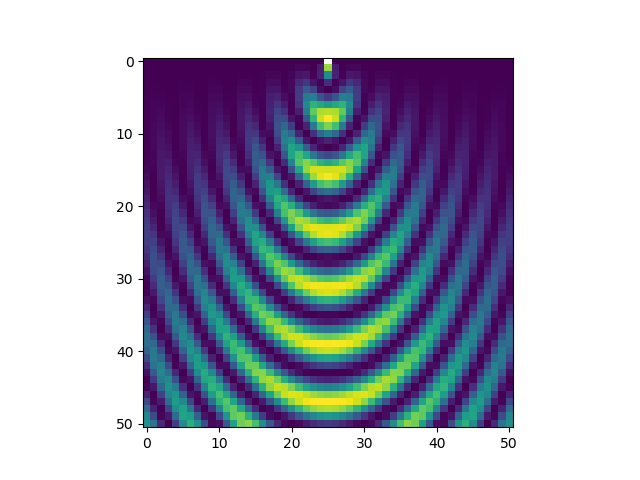

In [97]:
rabi_swp.start_amp(0)
rabi_swp.stop_amp(20)
rabi_swp.amp_points(51)
rabi_swp.start_det(-20)
rabi_swp.stop_det(20)
rabi_swp.det_points(51)
rabi_swp.setup()

det.set_sweeper(rabi_swp)
det.setup()

data = det.data()
print(data.shape, det.sweep_shape, det.sweep_dims, det.sweep_units)

fig, ax = plt.subplots(1,1)
ax.imshow(data.reshape(det.sweep_shape)[..., 0])